# Code for figure

In [2]:
from graph_tool.all import *
import pickle
import matplotlib

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
import sys

import collections
from collections import Counter
from matplotlib.lines import Line2D
import csv

from scipy import stats
import json


import matplotlib.ticker as mtick
from matplotlib.ticker import FormatStrFormatter
from scipy.stats import norm 
from sklearn.neighbors import KernelDensity 
from sklearn.utils.fixes import parse_version

#%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.rcParams.update({'font.size': 12, 'font.style': 'normal', 'font.family':'serif'})
    #matplotlib.rcParams.update({'font.size': 18})
    
    

def simpleaxis(ax,xlab_,ylab_):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.set_xlabel(xlab_,fontsize=ff) 
    ax.set_ylabel(ylab_,fontsize=ff)        
    plt.tight_layout()

%matplotlib inline
# %config InlineBackend.figure_format = 'svg'
plt.rcParams.update({'font.size': 8, 'font.style': 'normal', 'font.family':'serif'})
%config InlineBackend.figure_format = 'svg'
plt.rcParams.update({'font.size': 8, 'font.style': 'normal', 'font.family':'serif'})
#matplotlib.rcParams.update({'font.size': 18})
ff=8

In [3]:
# importing all our functions 
from functions_reci_bursty import *

In [4]:
from matplotlib.patches import PathPatch
from matplotlib.patches import Patch


# This is a function to adjust the space bw boxplots
def adjust_box_widths(g, fac):
    """
    Adjust the withs of a seaborn-generated boxplot.
    """

    # iterating through Axes instances
    for ax in g.axes:

        # iterating through axes artists:
        for c in ax.get_children():

            # searching for PathPatches
            if isinstance(c, PathPatch):
                # getting current width of box:
                p = c.get_path()
                verts = p.vertices
                verts_sub = verts[:-1]
                xmin = np.min(verts_sub[:, 0])
                xmax = np.max(verts_sub[:, 0])
                xmid = 0.5*(xmin+xmax)
                xhalf = 0.5*(xmax - xmin)

                # setting new width of box
                xmin_new = xmid-fac*xhalf
                xmax_new = xmid+fac*xhalf
                verts_sub[verts_sub[:, 0] == xmin, 0] = xmin_new
                verts_sub[verts_sub[:, 0] == xmax, 0] = xmax_new

                # setting new width of median line
                for l in ax.lines:
                    if np.all(l.get_xdata() == [xmin, xmax]):
                        l.set_xdata([xmin_new, xmax_new])

In [5]:
# a more general path that works for all -sam
x_dir=os.getcwd().split('/');
x_dir=os.getcwd().replace(x_dir[len(x_dir)-1],'')
os.chdir(x_dir+'data/data_raw')

fig_path = x_dir+'fig' # adri

# Adri's path
# os.chdir('/Users/adriana/Desktop/CEU/_COURSES/Dynamical/FinalProject/data')

# Elsa's path
#os.chdir('/home/utilisateur/Desktop/Dynamical_project/data')






In [6]:
#Path to save the figures
fig_path = x_dir+'fig' # adri

# fig_path = '/Users/adriana/Desktop/CEU/_COURSES/Dynamical/FinalProject/fig' # adri
#fig_path= '/home/utilisateur/Desktop/Dynamical_project/fig/' #elsa

# TABLE
____

In [7]:
TAB = pd.DataFrame(columns = ['Nber_events', 'Nber_links', 'Nber_nodes', 'Proba_rec_event', 'Proba_rec_edge', 'Burst_nodes', 'Burst_edges', 'data'])

names = ['calls','sms','msg','email', 'retweets', 'mentions']
for name in names: 
    print('\t working on: ', name,  end = "\r")
    
    
    # - Uploading graphs: g_filt !
    #------------------------------------------    
    name_store = open(x_dir+'data/graphs_fin/'+name+"_g_filt.pkl", "rb")
    g_filt = pickle.load(name_store)
    name_store.close()
    
    
    dict_tab = table(g_filt)
    dict_tab['data'] = name
    
    TAB = TAB.append(dict_tab, ignore_index=True)

In [8]:
TAB

,Nber_events,Nber_links,Nber_nodes,Proba_rec_event,Proba_rec_edge,Burst_nodes,Burst_edges,data
0,2430.0,181,252,0.440576,0.950276,0.206457,0.180625,calls
1,23779.0,473,482,0.738935,0.997886,0.458479,0.389915,sms
2,40600.0,3343,941,0.668315,0.873168,0.381343,0.170550,msg
3,306529.0,6864,753,0.449262,0.896562,0.450908,0.251657,email
4,57899.0,3142,1156,0.102180,0.328135,0.100730,0.060693,retweets
5,226774.0,8292,1609,0.108157,0.402315,0.237594,0.180821,mentions


In [8]:
# data=[]
# with open('CollegeMsg.txt', newline='') as csvfile:
#     spamreader = csv.reader(csvfile, delimiter=' ', quotechar='|')
#     for line in list(spamreader)[1:]:
#         L = np.asarray(line).astype(int)
#         data.append([L[0],L[1],L[2]])

# df_edges_col_msg= pd.DataFrame(data, columns = ['from', 'to', 't_second'])
# # df_edges_col_msg =make_time_col(df_edges_col_msg,'t_second')

# df_edges=df_edges_col_msg

# measures(df_edges,'college',5)

# FIGURES
---

## FUNCTIONS
___

In [9]:
# Function to convert network properties into a dataFrame. 

def data_prep(g_filt):

    # CREATING DFs
    #-------------------------------------
    #  a. Build a df for nodes 
    df_nodes = pd.DataFrame([g_filt.vp[p] for p in dict(g_filt.vertex_properties).keys()]).T
    df_nodes.columns = dict(g_filt.vertex_properties).keys()

    for col in ['burst_no_rec', 'burst_rec', 'n_rec_event','n_rec_link', 'proba_rec_event','proba_rec_link', 'burst']:
        df_nodes[col] = df_nodes[col].apply(float)

    for col in ['intertime_no_rec', 'intertime_rec', 'intertime']:
        df_nodes[col] = df_nodes[col].apply(lambda x: np.asarray(x))
        
        
    # b. Build a df for edges
    df_edges = pd.DataFrame([g_filt.ep[p] for p in dict(g_filt.edge_properties).keys()]).T
    df_edges.columns = dict(g_filt.edge_properties).keys()
    
    return df_nodes, df_edges

# NODES
____

## PLOTS FIGURE 1

In [10]:
def cum_F_x(dd):
    dist = Counter(dd)
    sorted_tuples = sorted(dist.items(), key=lambda item: item[0])
    sorted_dict = {k: v for k, v in sorted_tuples}
    
    x = np.array(list(sorted_dict.keys()))
    y = np.array(list(sorted_dict.values()))

    y_cum = np.cumsum(y)
    y_cum = y_cum/sum(y)
    return x, 1-y_cum

In [11]:
def F_x_bins(dd):
    dist = np.histogram(dd, bins = 100)
    y = dist[0]
    x =  [(dist[1][c]+dist[1][c+1])/2 for c in range(len(dist[1])-1)]
    #y = y/max(y)
    return x, y

In [12]:
names = ['calls','sms','msg','email', 'retweets', 'mentions']# 'msg','email'] 

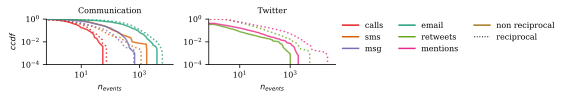

In [13]:
#-- New figure for you elsa with love adriana 

fig, axs = plt.subplots(1, 2, figsize =(8, 1.5), sharey='col', sharex='col')

c = ['#e41a1c','#d95f02','#7570b3','#1b9e77','#66a61e', '#e7298a','#a6761d']

titles  = ['Communication', 'Twitter']
lines   = [':', '-']

type_1 = ['n_non_rec_event', 'n_rec_event']
lw1=1.5
lw2=1
for i in range(2):
    for j,name in enumerate(names):  
        if j>3:
            col = 1
        else:
            col = 0
            

        # - Uploading graphs: g_filt !
        #------------------------------------------    
        name_store = open(x_dir+'data/graphs_fin/'+name+"_g_filt.pkl", "rb")
        g_filt = pickle.load(name_store)
        name_store.close()

        # - Preparing data 
        df_nodes,df_edges = data_prep(g_filt)
        df_nodes['n_non_rec_event'] = df_nodes['intertime_no_rec'].apply(len)
        
        #df_nodes['p_non_rec_event'] = df_nodes['n_non_rec_event']/max(df_nodes['n_non_rec_event'])
        #df_nodes['p_rec_event'] = df_nodes['n_rec_event']/max(df_nodes['n_rec_event'])

        # --- Number of Events  
        type_ = type_1[i]
        
        dd = np.array(df_nodes[type_])
        x,y = cum_F_x(dd)
        
        # Titles
        axs[col].set_title(titles[col],fontsize=ff)
        
        # Lines
        axs[col].plot(x, y, alpha = 0.8, ls = lines[i], label = name, c = c[j], lw=lw1 )
        axs[col].set_yscale('log')
        axs[col].set_xscale('log')
        axs[col].set_ylim(10**-4,10**0)
        
        # x axis Labels
        simpleaxis(axs[col],'$n_{events}$','') 

# y axis Labels
simpleaxis(axs[0],'$n_{events}$','$ccdf$') 



# Legend
custom_lines1 = [Line2D([0], [0], color=col, lw=lw1) for col in c]
custom_lines2  = [Line2D([0], [0], color='k', lw=lw2, ls=l) for l in [':', '-']]

#custom_lines = [*custom_lines1, *[Line2D([0], [0], color='white', lw=3)], *custom_lines2]
custom_lines = [*custom_lines1, *custom_lines2]
axs[1].legend(custom_lines, ['calls','sms', 'msg','email','retweets', 'mentions', 'non reciprocal', 'reciprocal'], ncol = 3, loc = 'lower left', 
              bbox_to_anchor = (1, .1), frameon = False,fontsize=ff)


 
plt.tight_layout()
plt.show()

fig.savefig(fig_path+'/fig1.pdf')

In [14]:
# try: burstiness vs p rec

In [15]:
df_comm_nodes = pd.DataFrame()
df_tw_nodes = pd.DataFrame()
df_comm_edges = pd.DataFrame()
df_tw_edges = pd.DataFrame()


for j,name in enumerate(names):  
    print(name)
    
    # - Uploading graphs: g_filt !
    #------------------------------------------    
    name_store = open(x_dir+'data/graphs_fin/'+name+"_g_filt.pkl", "rb")
    g_filt = pickle.load(name_store)
    name_store.close()
    
    
    # - Preparing data 
    df_nodes,df_edges = data_prep(g_filt)
        
    df_nodes['proba_rec_event_bin'] = pd.cut(df_nodes['proba_rec_event'], bins=[0.2, 0.4, .6, .8, 1])#q=[0.1, 0.6, .7, .8, .9, 1])#labels=False,precision=0)
        
    df_nodes['dataset'] = name
    df_edges['dataset'] = name
    if j <4:
        df_comm_nodes = pd.concat([df_comm_nodes,df_nodes])
        df_comm_edges = pd.concat([df_comm_edges,df_edges])
    else:
        df_tw_nodes = pd.concat([df_tw_nodes,df_nodes])
        df_tw_edges = pd.concat([df_tw_edges,df_edges])

calls
sms
msg
email
retweets
mentions


<ipython-input-4-bfdbdd1df548>:36: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if np.all(l.get_xdata() == [xmin, xmax]):


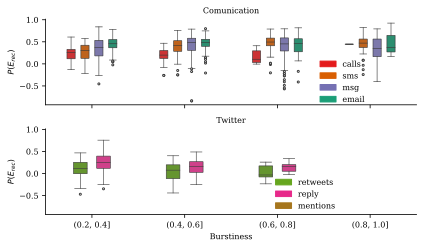

In [16]:
c = ['#e41a1c','#d95f02','#7570b3','#1b9e77','#66a61e', '#e7298a','#a6761d']
titles  = ['Comunication', 'Twitter']


fig, axs = plt.subplots(2, 1, figsize =(6, 3.5), sharey='col', sharex='col')


sns.boxplot(x="proba_rec_event_bin", y="burst",hue="dataset", palette=c[:4],data=df_comm_nodes, ax = axs[0], width = 0.6,notch=False,linewidth=0.6,
            flierprops=dict(markerfacecolor='w', marker="o" ,markersize = 2,))

sns.boxplot(x="proba_rec_event_bin", y="burst",hue="dataset", palette=c[4:],data=df_tw_nodes, ax = axs[1], width = 0.5,notch=False,linewidth=0.6,
            flierprops=dict(markerfacecolor='w', marker="o" ,markersize = 2,))

adjust_box_widths(fig, 0.6)

for col in range(2):
    #Label
#     axs[col].set_ylabel('Burstiness')
    
    # Titles
    axs[col].set_title(titles[col],fontsize=ff)
    simpleaxis(axs[col],'Burstiness','$P(E_{rec})$') 
axs[0].set_xlabel('')

simpleaxis(axs[1],'Burstiness','$P(E_{rec})$')     
# Legend
custom_lines1 =[Patch(facecolor=col, edgecolor=col,label='Color Patch') for col in c[:4]]
axs[0].legend(custom_lines1, ['calls','sms', 'msg','email'], ncol = 1,fontsize=ff,frameon=False,\
             bbox_to_anchor = (.8, .6))

custom_lines1 =[Patch(facecolor=col, edgecolor=col,label='Color Patch') for col in c[4:]]
axs[1].legend(custom_lines1, ['retweets', 'reply', 'mentions',], ncol = 1,fontsize=ff,frameon=False,\
             bbox_to_anchor = (.8, .5))
plt.tight_layout()#h_pad=1.0
    
plt.show()
# fig.savefig(fig_path+'/figSI1.pdf')

## PLOTS FIGURE 2

## Doing bootstrap
----

In [17]:
# BOOTSTRAP 
def boot(df_nodes):
    N_ex = 5000
    sample_size = 1000

    B_mean = []
    B_std = []

    Inter_mean = []
    Inter_std =[]

    for ex in range(N_ex):
        print(ex, end = "\r")
        df_sample = df_nodes.sample(n=sample_size, replace=True, axis=0) 

        # Burstiness
        B_mean.append(df_sample.describe().loc['mean',:][['burst_no_rec', 'burst_rec', 'burst']])
        B_std.append(df_sample.describe().loc['std',:][['burst_no_rec', 'burst_rec', 'burst']])

        # Intertime
        I_no_rec = np.concatenate(list(df_sample['intertime_no_rec']))
        I_rec = np.concatenate(list(df_sample['intertime_rec']))
        I_all = np.concatenate(list(df_sample['intertime']))

        Inter_mean.append([np.mean(I_no_rec), np.mean(I_rec), np.mean(I_all)])
        Inter_std.append([np.std(I_no_rec), np.std(I_rec), np.std(I_all)])
        
    B_mean = np.array(B_mean).T
    B_std = np.array(B_std).T

    Inter_mean = np.array(Inter_mean).T
    Inter_std = np.array(Inter_std).T
    
    return B_mean, B_std, Inter_mean, Inter_std

names = ['sms', 'msg','email','calls', 'retweets', 'mentions', ]#'test']# 'msg','email'] 
##['calls', 'sms', 'mentions','retweets', 'reply','msg','email'

#https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ks_2samp.html

In [18]:
# LOAD DATA
a_file = open(x_dir+'data/DATA.pkl', "rb")
DATA = pickle.load(a_file)
#print(DATA)

---

In [19]:
# fig, axs = plt.subplots(3, len(DATA.keys()), figsize =(3*len(DATA.keys()), 7))#, sharex='row') #sharey='row'
# c = ['blue', 'orange', 'grey']

# param_fit = [0.01,0.01,0.05,0.05,0.4,0.2,0.4]
# param_fit_burst = [0.05,0.05,0.05,0.05,0.05,0.05,0.05]

# props = dict(boxstyle='round', facecolor='white', alpha=0.5)

# for col, name in enumerate(DATA.keys()):
    
#     fit = param_fit[col]    
#     fit_burst = param_fit_burst[col]
    
#     # - Setting the name of the column (dataset)
#     axs[0,col].set_title(name)   

#     # Preparing data
#     data = DATA[name]
      
#     # AM: This is actually unuseful we could already imput the values from the dict...
#     B_mean= data['B_mean']
#     B_std= data['B_std']
#     Inter_mean= data['Inter_mean']
#     Inter_std= data['Inter_std']
    
#     #pvalue_B_tt = data['pvalue_B_tt']
#     #pvalue_InterM_tt = data['pvalue_InterM_tt']
#     #pvalue_InterStd_tt = data['pvalue_InterStd_tt']
    
#     #pvalue_B_ks = data['pvalue_B_ks']
#     #pvalue_InterM_ks = data['pvalue_InterM_ks']
#     #pvalue_InterStd_ks = data['pvalue_InterStd_ks']
    
    
#     scale = 60*60*24
#     x_scale = 'Days'

#     for i,label in enumerate(['Non-Reciprocal','Reciprocal', 'Overall']): 
        
#         if label == 'Overall':
#             alpha = 0.7
#         else:
#             alpha = 1
            
#         # -- Intertime Mean
        
#         Inter_mean_plot = Inter_mean[i]/scale
        
#         # Adriana and Elsa code
#         #sns.kdeplot(Inter_mean_plot, color=c[i], ax=axs[0,col],common_norm = True,label=label)
        
#         # Sandeep code
#         kde = KernelDensity(kernel='gaussian', bandwidth=fit).fit(Inter_mean_plot.reshape(-1, 1)) 
#         s = np.linspace(0,round(max(Inter_mean_plot)+1),num = 100) 
#         log_dens = kde.score_samples(s.reshape(-1,1)) 
        
#         axs[0,col].plot(s,np.exp(log_dens),color=c[i],label=label, alpha = alpha)
#         axs[0,col].hist(Inter_mean_plot,alpha = 0.25,density=True, edgecolor = c[i])
#         axs[0,col].axvline(np.mean(Inter_mean_plot), 0, 21, c=c[i], alpha=0.7, ls='--', label='')   
        
#         axs[0,col].set_xlabel(x_scale)
        
        
#         # -- Intertime Std
        
#         #Inter_std[i] = Inter_std[i]/scale
        
#         Inter_std_plot = Inter_std[i]/scale
#         #sns.kdeplot(Inter_std_plot, color=c[i], ax=axs[1,col], common_norm = True,label=label)
        
#         # Sandeep code
#         kde = KernelDensity(kernel='gaussian', bandwidth=fit).fit(Inter_std_plot.reshape(-1, 1)) 
#         s = np.linspace(0,round(max(Inter_std_plot)+1),num = 100) 
#         log_dens = kde.score_samples(s.reshape(-1,1)) 
        
#         axs[1,col].plot(s,np.exp(log_dens),color=c[i],label=label, alpha = alpha)
#         axs[1,col].hist(Inter_std_plot,alpha = 0.25, density=True, edgecolor = c[i])
#         axs[1,col].axvline(np.mean(Inter_std_plot), 0, 21, c=c[i], alpha=0.7, ls='--', label='')   
        
#         axs[1,col].set_xlabel(x_scale)
    
            
#         # -- Burstiness
        
#         B_mean_plot = B_mean[i]
                
#         # Sandeep code
#         kde = KernelDensity(kernel='gaussian', bandwidth=0.01).fit(B_mean_plot.reshape(-1, 1)) 
#         s = np.linspace(-1,1,num = 100) 
#         log_dens = kde.score_samples(s.reshape(-1,1)) 
        
        
#         axs[2,col].plot(s,np.exp(log_dens),color=c[i],label=label, alpha = alpha)
#         axs[2,col].hist(B_mean_plot,alpha = 0.25,density=True, edgecolor = c[i])
#         axs[2,col].axvline(np.mean(B_mean_plot), 0, 21, c=c[i], alpha=0.7, ls='--', label='')   
        
#         axs[2,col].set_xlim(-1, 1) #<--- AM: I changed the range make the x axis larger
#         axs[2,col].set_xlabel('Burtiness')
        
#         #axs[2,col].set_ylim(0, 9)
        
#     for j in range(3):
#         axs[j,col].set_ylabel('')

# f = 10
# axs[0,0].set_ylabel('$P_{x}(Intertime \; Mean)$',fontsize=f)
# axs[1,0].set_ylabel('$P_{x}(Intertime \; Std)$',fontsize=f)
# axs[2,0].set_ylabel('$P_{x}(Burstiness \; Mean)$\n',fontsize=f)

# fig.align_ylabels(axs[:, 0])
# axs[2,3].legend(loc='lower center', ncol = 3, bbox_to_anchor=(0.5, -0.6))
       
# fig.tight_layout(pad=2.0)
# plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=.3, hspace=.35)
# # fig.savefig(fig_path+'/fig2.pdf')

In [20]:
names

['sms', 'msg', 'email', 'calls', 'retweets', 'mentions']

# Entire distribution: no bootstrap

In [21]:


df_comm_nodes = pd.DataFrame()
df_tw_nodes = pd.DataFrame()
df_comm_edges = pd.DataFrame()
df_tw_edges = pd.DataFrame()


for j,name in enumerate(names):  
    print(name+'\t\t', end = '\r')

    
    # - Uploading graphs: g_filt !
    #------------------------------------------    
    name_store = open(x_dir+'data/graphs_fin/'+name+"_g_filt.pkl", "rb")
    g_filt = pickle.load(name_store)
    name_store.close()

    # - Preparing data 
    df_nodes,df_edges = data_prep(g_filt)
    df_nodes['dataset'] = name
    df_edges['dataset'] = name

    
    
    if j <4:
        df_comm_nodes = pd.concat([df_comm_nodes,df_nodes])
        df_comm_edges = pd.concat([df_comm_edges,df_edges])

    else:
        df_tw_nodes = pd.concat([df_tw_nodes,df_nodes])
        df_tw_edges = pd.concat([df_tw_edges,df_edges])

        
df_all_nodes =  pd.concat([df_comm_nodes,df_tw_nodes])
df_all_edges =  pd.concat([df_comm_edges,df_tw_edges])

In [22]:
for col in ['intertime_no_rec', 'intertime_rec', 'intertime']:
    df_all_nodes[col+'_mean'] = df_all_nodes[col].apply(np.mean)/ (60*60*24)
    df_all_nodes[col+'_std'] = df_all_nodes[col].apply(np.std)/ (60*60*24)

    df_all_nodes['len_'+col] = df_all_nodes[col].apply(len) 
    

    
#df_all_nodes.head(1)

/mnt/sdb1/sandeep/miniconda3/envs/sos/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/mnt/sdb1/sandeep/miniconda3/envs/sos/lib/python3.9/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


In [23]:
df_all_nodes[(df_all_nodes['burst_no_rec'] ==-1) &(df_all_nodes['len_intertime_no_rec'] ==14)][['burst_no_rec', 'intertime_no_rec']]

,burst_no_rec,intertime_no_rec


In [24]:
# Nodes with burstiness no rec == -1

# the problem is basically for mentions
# 1. we need a way to remove list of interitme = 1 ie. only to events
# 2. we need a way to discard for the sistibution thar are all equal: ie st = 0 : only in mentions and rt: bots ??? 

A =df_all_nodes[(df_all_nodes['burst_no_rec'] ==-1) ]
A.groupby(['dataset', 'len_intertime_no_rec'])['intertime_no_rec_std'].mean().reset_index()

,dataset,len_intertime_no_rec,intertime_no_rec_std
0,calls,1,0.0
1,email,1,0.0
2,mentions,1,0.0
3,mentions,2,0.0
4,msg,1,0.0
5,retweets,1,0.0
6,retweets,3,0.0
7,sms,1,0.0


In [25]:
A =df_all_nodes[(df_all_nodes['burst'] ==-1) ]
A.groupby(['dataset', 'len_intertime'])['intertime_std'].mean().reset_index()

,dataset,len_intertime,intertime_std


In [26]:
A =df_all_nodes[(df_all_nodes['burst_rec'] ==-1) ]
A.groupby(['dataset', 'len_intertime_rec'])['intertime_rec_std'].mean().reset_index()

,dataset,len_intertime_rec,intertime_rec_std
0,calls,1,0.0
1,email,1,0.0
2,mentions,1,0.0
3,msg,1,0.0
4,retweets,1,0.0
5,sms,1,0.0


In [27]:
for col in ['intertime_no_rec', 'intertime_rec', 'intertime']:
    df_all_edges[col+'_mean'] = df_all_edges[col].apply(np.mean)/ (60*60*24)
    df_all_edges[col+'_std'] = df_all_edges[col].apply(np.std)/ (60*60*24)

    df_all_edges['len_'+col] = df_all_edges[col].apply(len) 
    

/mnt/sdb1/sandeep/miniconda3/envs/sos/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/mnt/sdb1/sandeep/miniconda3/envs/sos/lib/python3.9/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


In [28]:
bb = ['burst_rec', 'burst_no_rec', 'burst']
ii = ['intertime_rec', 'intertime_no_rec', 'intertime']

tt = ['rec', 'no_rec', 'all']

c = ['#e41a1c','#d95f02','#7570b3','#1b9e77','#66a61e', '#e7298a','#a6761d']

In [29]:
# fig, axs = plt.subplots(1, 3, figsize =(2.5*6, 4))# sharey='row')#, sharex='row') #sharey='row'

# for cc in range(3):
    
#     for n, name in enumerate(names):
#         d = df_all_nodes[df_all_nodes['dataset'] ==name]
#         d = d[d[bb[cc]] == -1]
    
#         x = np.array(d['len_'+ii[cc]])
#         y =  np.array(d[bb[cc]])
        
        
#         axs[cc].set_xlabel('len intertime')
        

#         #axs[cc].scatter(x, y, alpha = 0.8, label = name, c = c[n], lw=0.6 )
#         axs[cc].hist(x, alpha = 0.5, label = name, color = c[n], lw=0.6 )
#         axs[cc].set_title(tt[cc])
        
        
    
# #axs[0].set_ylabel('Burstiness') ;

In [30]:
# dd_all = df_all_nodes[(df_all_nodes['intertime_rec_std']>0) & (df_all_nodes['intertime_no_rec_std']>0) & (df_all_nodes['intertime_std']>0)]


In [31]:
# df_all_edges

In [32]:
dd_all_edges = df_all_edges[(df_all_edges['intertime_rec_std']>0) & (df_all_edges['intertime_no_rec_std']>0) & (df_all_edges['intertime_std']>0)]
# dd_all_edges=df_all_edges.copy()


In [33]:
param_fit = [0.01,0.01,0.05,0.05,0.4,0.2,0.4]
param_fit_burst = [0.05,0.05,0.05,0.05,0.05,0.05,0.05]

sms
intertime_no_rec_mean  mean  1.2547474170486819 min  0.00013310185185185186 max  10.030133101851852
intertime_rec_mean  mean  0.4956221485406671 min  0.0004890046296296296 max  9.461024305555556
,  inter KstestResult(statistic=0.3022598870056497, pvalue=1.1320072648350939e-14)
$10^{-14}$
burst_no_rec  mean  0.1519745516433384 min  -0.9916173570019724 max  0.7312915518766757
burst_rec  mean  0.3899081216519888 min  -0.6579915593550482 max  0.7894362953788886
,  burst KstestResult(statistic=0.4265536723163842, pvalue=2.8514249164572825e-29)
$10^{-29}$
msg
intertime_no_rec_mean  mean  3.8630969368311097 min  3.18287037037037e-05 max  77.01683449074073
intertime_rec_mean  mean  1.7302050558409237 min  0.00028356481481481483 max  54.41745370370371
,  inter KstestResult(statistic=0.16039279869067102, pvalue=3.932127397953994e-14)
$10^{-14}$
burst_no_rec  mean  0.010699534490270267 min  -0.9781414308501211 max  0.756836375975952
burst_rec  mean  0.09755026709311632 min  -0.984 max  0.7904

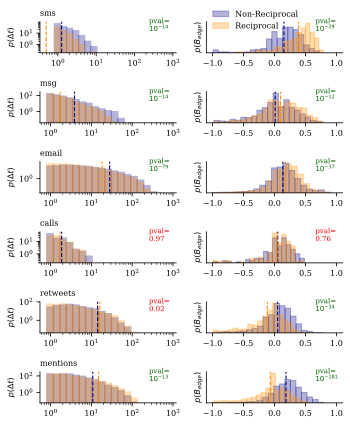

In [40]:
fig, axs = plt.subplots( len(names),2, figsize =(5,1*len(names)))# sharey='row')#, sharex='row') #sharey='row'
c = ['blue', 'orange', 'grey']

c = ['navy','darkorange','red' 'cornflowerblue']
col_=['navy','darkorange' ,'cornflowerblue']
labels = ['Non-Reciprocal','Reciprocal', 'Overall']
lines   = [':', ':', '-']
ff = 8;f=ff
n_bins=20         
ylab1='$p(\Delta t)$'
ylab2='$p(B_{edge})$'
for col,name in enumerate(names):
    print(name)
    fit = param_fit[col]    
    fit_burst = param_fit_burst[col]
    
    # - Setting the name of the column (dataset)
    axs[col,0].set_title(name,fontsize=ff,loc='left')
    axs[col,0].set_xlabel('Days')
    axs[col,1].set_xlabel('Burstiness')
    axs[col,1].set_xlim(-1.1, 1.1); #<--- AM: I changed the range make the x axis larger
    
    # - Preparing data 
    #df_nodes = df_all_nodes[df_all_nodes['dataset'] == name] 
    df_nodes = dd_all_edges[dd_all_edges['dataset'] == name]
    
    for row,var_list in enumerate([['intertime_no_rec_mean', 'intertime_rec_mean', 'intertime_mean'], ['burst_no_rec', 'burst_rec', 'burst']]): 
#     for row,var_list in enumerate([['burst_no_rec', 'burst_rec']]): 
        store_for_KS2samp=[]
 
        for i in range(2):  
            variable = np.array([v for v in df_nodes[var_list[i]] if str(v)!= 'nan'])
            store_for_KS2samp.append(variable)
            color = c[i]
            label = labels[i]
            axs[col, row].set_ylabel('')
            axs[col, row].axvline(np.mean(variable), 0, 41, c=col_[i], alpha=1, ls='--', label='', lw=1.1)  
            
            print(var_list[i],' mean ',np.mean(variable), 'min ',np.min(variable),'max ',np.max(variable))
            if row == 1:
                # Burstiness
                axs[col, row].hist(variable,n_bins, alpha = 0.3, density=False, edgecolor = c[i], label = label, color = c[i])

                #axs[col, row].set_xscale('log')
                #axs[col, row].set_xlim(0, 20)
                axs[col, row].set_yticks([])
                # Sandeep code
#                 X=variable.reshape(-1, 1)
#                 kde = KernelDensity(kernel='gaussian', bandwidth=0.1).fit(X) 
#                 s = np.linspace(min(X),max(X),n_bins) 
#                 log_dens = kde.score_samples(s.reshape(-1,1)) 
#                 axs[col, row].plot(s,np.exp(log_dens),color=c[i],label=label, alpha = alpha)
                simpleaxis(axs[col, row],'',ylab2)
                
            else:
                # log-scaled bins
                bins = np.logspace(0, 3, n_bins)
                widths = (bins[1:] - bins[:-1])

                # Calculate histogram
                hist = np.histogram(variable, bins=bins)
                hist_norm = hist[0]/widths
                

                # plot it!
                axs[col, row].bar(bins[:-1], hist_norm, widths,color = c[i],alpha = 0.3)
                axs[col, row].set_xscale('log')
                axs[col, row].set_yscale('log')
                simpleaxis(axs[col, row],'',ylab1)

                
                #axs[col, row].hist(variable,alpha = 0.5, density=False, edgecolor = c[i], label = label, color = c[i], bins = 50)
                #axs[col, row].set_xscale('log')
                #axs[col, row].set_yscale('log')
                #axs[col, row].set_xlim(0, 20)
                #x,y = cum_F_x(variable)
                #y =1-y
        
                # Lines
                #axs[col, row].plot(x, y, alpha = 0.8, ls = lines[i], label = label, c = c[i], lw=0.6 )
                #axs[col, row].scatter(x, y, alpha = 0.8, ls = lines[i], label = label, c = c[i], lw=0.01, marker = 'o' )
                
                #axs[col, row].set_yscale('log')
                #axs[col, row].set_xscale('log')
                #axs[col, row].set_ylim(10**-4,10**0)
        print(', ',var_list[0][0:5],stats.ks_2samp(store_for_KS2samp[0],store_for_KS2samp[1]))
        x_text=stats.ks_2samp(store_for_KS2samp[0],store_for_KS2samp[1])
        if x_text[1]<0.01:color_p='darkgreen'
        else:color_p='red'
        xx=str(x_text[1])
        if 'e' in xx:xx=xx.split('e');x_text=(xx[0][0:3]+'e'+xx[1]);            x_text=('$10^{'+xx[1]+'}$')
        elif len(xx)<3: x_text=x;
        else:            x_text=(xx[0:4])
        print(x_text)
        
        axs[col, row].annotate('pval=\n'+x_text,[.6,.65],xytext=(0.8, 0.7), textcoords='axes fraction',
                              fontsize=7,color=color_p)
                            
        
axs[0,1].legend(loc='lower center', ncol = 1, bbox_to_anchor=(.36, 0.5),frameon=False);
#plt.show()
plt.tight_layout()#h_pad=1.0

fig.savefig(fig_path+'/fig2_2.pdf')


# B_nodes plot

In [35]:
# fig, axs = plt.subplots(2, len(names), figsize =(2*len(names), 6))# sharey='row')#, sharex='row') #sharey='row'
# c = ['blue', 'orange', 'grey']
# labels = ['Non-Reciprocal','Reciprocal', 'Overall']
# lines   = [':', ':', '-']

# for col,name in enumerate(names):
    
#     fit = param_fit[col]    
#     fit_burst = param_fit_burst[col]
    
#     # - Setting the name of the column (dataset)
#     axs[0,col].set_title(name)
#     axs[0, col].set_xlabel('Days')
#     axs[1, col].set_xlabel('Burstiness')
#     axs[1, col].set_xlim(-1.2, 1.2); #<--- AM: I changed the range make the x axis larger
    
#     # - Preparing data 
#     #df_nodes = df_all_nodes[df_all_nodes['dataset'] == name] 
#     df_nodes = dd_all[dd_all['dataset'] == name]
    
#     for row,var_list in enumerate([['intertime_no_rec_mean', 'intertime_rec_mean', 'intertime_mean'], ['burst_no_rec', 'burst_rec', 'burst']]): 
 
#         for i in range(3):  
#             variable = np.array([v for v in df_nodes[var_list[i]] if str(v)!= 'nan'])
#             color = c[i]
#             label = labels[i]
#             axs[col, row].set_ylabel('')
#             axs[col, row].axvline(np.mean(variable), 0, 21, c=c[i], alpha=0.7, ls='--', label='', lw=1.4)  
            
            
#             if row == 1:
#                 # Burstiness
#                 axs[col, row].hist(variable,alpha = 0.5, density=False, edgecolor = c[i], label = label, color = c[i])
                
#                 #axs[col, row].set_xscale('log')
#                 #axs[col, row].set_xlim(0, 20)
#             else:
#                 # log-scaled bins
#                 bins = np.logspace(0, 3, 20)
#                 widths = (bins[1:] - bins[:-1])

#                 # Calculate histogram
#                 hist = np.histogram(variable, bins=bins)
#                 hist_norm = hist[0]/widths

#                 # plot it!
#                 axs[col, row].bar(bins[:-1], hist_norm, widths,color = c[i],alpha = 0.5)
#                 axs[col, row].set_xscale('log')
#                 axs[col, row].set_yscale('log')
                
                
#                 #axs[col, row].hist(variable,alpha = 0.5, density=False, edgecolor = c[i], label = label, color = c[i], bins = 50)
#                 #axs[col, row].set_xscale('log')
#                 #axs[col, row].set_yscale('log')
#                 #axs[col, row].set_xlim(0, 20)
#                 #x,y = cum_F_x(variable)
#                 #y =1-y
        
#                 # Lines
#                 #axs[col, row].plot(x, y, alpha = 0.8, ls = lines[i], label = label, c = c[i], lw=0.6 )
#                 #axs[col, row].scatter(x, y, alpha = 0.8, ls = lines[i], label = label, c = c[i], lw=0.01, marker = 'o' )
                
#                 #axs[col, row].set_yscale('log')
#                 #axs[col, row].set_xscale('log')
#                 #axs[col, row].set_ylim(10**-4,10**0)
        
                
            
            
# f = 8
# axs[0,0].set_ylabel('$P_{x}(Intertime)$',fontsize=f)
# axs[1,0].set_ylabel('$P_{x}(Burstiness)$',fontsize=f)

# axs[1,3].legend(loc='lower center', ncol = 3, bbox_to_anchor=(0.5, -0.5))
# #plt.show()
# # fig.savefig(fig_path+'/fig2_2.pdf')
# plt.tight_layout()#h_pad=1.0


# EDGES 
____

In [36]:
bins = np.logspace(0, 2, 50)


In [37]:
# # log-scaled bins
# bins = np.logspace(0, 3, 50)
# widths = (bins[1:] - bins[:-1])

# # Calculate histogram
# hist = np.histogram(data, bins=bins)
# # normalize by bin width
# hist_norm = hist[0]/widths

# # plot it!
# plt.bar(bins[:-1], hist_norm, widths)
# plt.xscale('log')
# plt.yscale('log')

In [38]:
names = ['calls', 'sms', 'msg', 'email', 'retweets', 'reply','mentions']

In [39]:
df_comm = pd.DataFrame()
df_tw = pd.DataFrame()


for j,name in enumerate(names):  
    print(name)

    
    # - Uploading graphs: g_filt !
    #------------------------------------------    
    name_store = open(x_dir+'data/graphs_fin/'+name+"_g_filt.pkl", "rb")
    g_filt = pickle.load(name_store)
    name_store.close()

    # - Preparing data 
    df_nodes = data_prep(g_filt)[1]
    df_nodes['dataset'] = 'name'
    #df_nodes = df_nodes[df_nodes['balance']!= 1]
        
    df_nodes['p_Erec_bin'] = pd.cut(df_nodes['p_Erec'], bins=10)
    df_nodes['balance_bin'] = pd.cut(df_nodes['balance'], bins=[0.49, 0.6, .7, .8, .9, 1])#labels=False,precision=0)
        
    df_nodes['dataset'] = name
    if j <4:
        df_comm = pd.concat([df_comm,df_nodes])
    else:
        df_tw = pd.concat([df_tw,df_nodes])
            

calls
sms
msg
email
retweets
reply
mentions


In [40]:
df_tw=df_tw.sort_values(by=['balance'])
df_tw['balance_bin'].unique()

[(0.49, 0.6], (0.6, 0.7], (0.7, 0.8], (0.8, 0.9], (0.9, 1.0]]
Categories (5, interval[float64]): [(0.49, 0.6] < (0.6, 0.7] < (0.7, 0.8] < (0.8, 0.9] < (0.9, 1.0]]

<ipython-input-3-bfdbdd1df548>:36: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if np.all(l.get_xdata() == [xmin, xmax]):


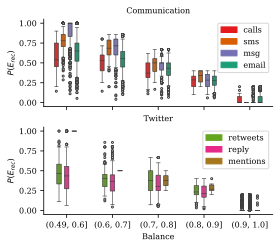

In [41]:
c = ['#e41a1c','#d95f02','#7570b3','#1b9e77','#66a61e', '#e7298a','#a6761d']
titles  = ['Communication', 'Twitter']


fig, axs = plt.subplots(2, 1, figsize =(4, 3.5), sharey='col', sharex='col')


sns.boxplot(x="balance_bin", y="p_Erec",hue="dataset", palette=c[:4],data=df_comm, ax = axs[0], width = 0.6,notch=False,linewidth=0.6, whis = 0.9, 
            flierprops=dict(markerfacecolor='w', marker="o" ,markersize = 2,))

sns.boxplot(x="balance_bin", y="p_Erec",hue="dataset", palette=c[4:],data=df_tw, ax = axs[1], width = 0.5,notch=False,linewidth=0.6,whis = 0.9,
            flierprops=dict(markerfacecolor='w', marker="o" ,markersize = 2,))

adjust_box_widths(fig, 0.6)

for col in range(2):
    #Label
    simpleaxis(axs[col],'Balance','$P(E_{rec})$')
    
    # Titles
    axs[col].set_title(titles[col],fontsize=ff)
axs[0].set_xlabel('')
# axs[1].set_xlabel('Balance')
    
# Legend
custom_lines1 =[Patch(facecolor=col, edgecolor=col,label='Color Patch') for col in c[:4]]
axs[0].legend(custom_lines1, ['calls','sms', 'msg','email'], ncol = 1)

custom_lines1 =[Patch(facecolor=col, edgecolor=col,label='Color Patch') for col in c[4:]]
axs[1].legend(custom_lines1, ['retweets', 'reply', 'mentions',], ncol = 1)
    
plt.show()
fig.savefig(fig_path+'/fig3.pdf')

In [42]:
# lascia il boz plot and dire nel papaer coms sono distribuiti i valori 

In [46]:
# dd = df_comm.groupby(['dataset', 'balance_bin', 'p_Erec_bin']).size().reset_index()
# dd[dd['dataset'] == 'msg']
# #dd

In [69]:
#dd = df_comm.groupby(['dataset', 'balance_bin', ])['p_Erec'].size().reset_index()


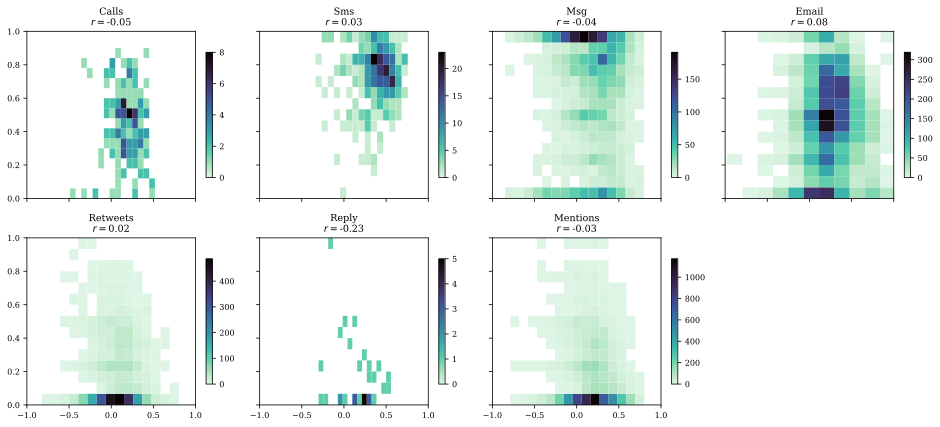

In [72]:
# fig supplementary
import scipy
from matplotlib.colors import LogNorm
names = ['calls','sms','msg','email', 'retweets', 'reply', 'mentions']# 'msg','email'] 
f = 12

fig, axs = plt.subplots(2, 4, figsize =(4*3.3, 3*2), sharey = True, sharex=True)
for j,name in enumerate(names): 
    data = df_edges[['burst', 'p_Erec']]
    log_norm = LogNorm(vmin=1, vmax=data.max().max())
    
    #print(j//4, j%4)

    # - Uploading graphs: g_filt !
    #------------------------------------------    
    name_store = open(x_dir+'data/graphs_fin/'+name+"_g_filt.pkl", "rb")
    g_filt = pickle.load(name_store)
    name_store.close()

    # - Preparing data 
    df_nodes,df_edges = data_prep(g_filt)
    
    p = round(scipy.stats.pearsonr(df_edges['burst'].values,df_edges['p_Erec'].values)[0],2)
    
    axs[j//4, j%4].set_title('{}\n$r=${}'.format(name.capitalize(),p))
    axs[j//4, j%4].set_xlim((-1, 1))
    axs[j//4, j%4].set_ylim((0., 1))
    
    x = df_edges['burst'].values
    y = df_edges['p_Erec'].values
    sns.histplot(x=x, y=y,
                 cmap="mako_r", bins=15,
                 
                 discrete=(False, False), 
                 log_scale=(False, False)# this is for the axis 
                 ,cbar=True,cbar_kws=dict(shrink=.75),
                 
#                  norm=LogNorm(), # this is for the color bar 
#                  norm=log_norm,
                 ax = axs[j//4, j%4]) 

#     plt.hist2d(x,y,100,norm=LogNorm(),cmap='mako_r')


fig.delaxes(axs[1][3])
plt.tight_layout()
plt.savefig('correlation_burstiness_reciprocity')

In [48]:
#---- end 